In [1]:
%env CUDA_VISIBLE_DEVICES=2
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('bmh')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=2


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

def train_sampling_pattern(train_generator, model, n=14):
    criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
    c, bmasks, images, bmean, bstd = next(iter(train_generator))
    bks = Ft(images * bstd + bmean)
    bgt = IFt(bks).abs()
    w = torch.zeros(256, 256).cuda().float()
    w[:,128] = 1
    bbatch = 32
    w_list = []
    pbar = tqdm(range(n))
    for count in pbar:
        w = torch.autograd.Variable(w, requires_grad=True)
        for j in range(bks.shape[0] // bbatch):
            bbks = bks[bbatch*j:bbatch*(j+1)].cuda()
            bbgt = bgt[bbatch*j:bbatch*(j+1)].cuda()
            bbmean = bmean[bbatch*j:bbatch*(j+1)].cuda()
            bbstd = bstd[bbatch*j:bbatch*(j+1)].cuda()
            bbmasks = bmasks[bbatch*j:bbatch*(j+1)].cuda()
            recs = IFt(bbks * w).abs()
            pm = model((recs - bbmean) / (bbstd + 1e-11))
            loss = criterion(pm, bbmasks.long())
            loss.backward()
        for i in torch.topk(w.grad.flatten(), 256*256, largest=False).indices:
            if w.flatten()[i] == 0: 
                w = w.detach().flatten()
                w[i] = 1.
                w = w.unflatten(0, (256,256))
                w_list.append(w.clone().cpu())
                pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                break
    return w_list

def test_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 1
    for j in tqdm(range(vbks.shape[0] // bbatch)):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].cuda()
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].cuda()
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].cuda()
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].cuda()
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].cuda()
        with torch.no_grad():
            # igs
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(1 - dice_loss(vbbmasks.long(), pm).item())
    return dice_scores

def test_on_classes_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 1
    for j in tqdm(range(vbks.shape[0] // bbatch)):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].cuda()
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].cuda()
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].cuda()
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].cuda()
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].cuda()
        with torch.no_grad():
            # igs
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(dice_coeffs(vbbmasks.long(), pm))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path: str):
        super().__init__()
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return c, mask, img, mean.unsqueeze(0).unsqueeze(0).unsqueeze(0), std.unsqueeze(0).unsqueeze(0).unsqueeze(0)

In [3]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
np.random.seed(42)
torch.manual_seed(42)
train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5')
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5')
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=6)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('unet-acdc-norot.pt'))

<All keys matched successfully>

# 5-fold validation x16

In [6]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((256, 256))[0]).cuda().float()
zm = torch.zeros(256,256).cuda().float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2, 256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    w_list = train_sampling_pattern(tg, model, n=16)
    dice_fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[14], model, vg),
        fastmri=test_sampling_pattern(fastmri_mask_x16, model, vg), 
        center=test_sampling_pattern(zm, model, vg),
    )
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in dice_fold_scores.values()]
with open('unet_fold_scores.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

In [7]:
with open('unet_fold_scores.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [8]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-9.931175691329084, pvalue=0.000577229770897802)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.658307,0.757396,0.790565
std,0.045223,0.028518,0.028777
min,0.617922,0.725980,0.755459
25%,0.631727,0.729717,0.763612
50%,0.634449,0.765502,0.804492
75%,0.679742,0.774695,0.813852
max,0.727693,0.791087,0.815408


# Training on full train

In [ ]:
w_list = train_sampling_pattern(train_generator, model, n=5000)

In [8]:
torch.save(w_list, 'sampling_2d_igs.pt')

In [9]:
w_list[-1].sum()

tensor(5256.)

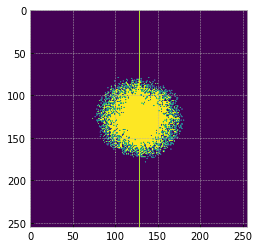

In [10]:
plt.imshow(w_list[-1])

In [11]:
w = torch.load('sampling_2d_igs.pt')[-1]

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [float(256*256 / w.sum())])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(256 / (256*256 / w.sum()))//2 : 256//2 + int(256 / (256*256 / w.sum()))//2] = 1
zm2 = torch.zeros(256, 256).cuda().float()
zm2[256//2 - int(w.sum()**0.5+1)//2:256//2 + int(w.sum()**0.5+1)//2, 256//2 - int(w.sum()**0.5+1)//2:256//2 + int(w.sum()**0.5+1)//2] = 1
fm = torch.ones(256).cuda().float()

In [12]:
fastmri_mask_x16.sum(), zm.sum(), zm2.sum(), w.sum()

(tensor(21., device='cuda:0'),
 tensor(20., device='cuda:0'),
 tensor(5184., device='cuda:0'),
 tensor(5256.))

In [13]:
dice_scores = dict(
    fastmri=test_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_sampling_pattern(zm, model, val_generator),
    center2d=test_sampling_pattern(zm2, model, val_generator),
    ours=test_sampling_pattern(w.cuda(), model, val_generator),
)

In [14]:
df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,fastmri,center,center2d,ours
count,514.000000,514.000000,514.000000,514.000000
mean,0.566204,0.690101,0.813481,0.815258
std,0.199179,0.214193,0.185630,0.184340
min,0.236721,0.245490,0.247269,0.247325
25%,0.416039,0.573333,0.761895,0.762545
50%,0.594005,0.787003,0.901032,0.901980
75%,0.747023,0.860908,0.931016,0.932031
max,0.858473,0.923622,0.959758,0.961427


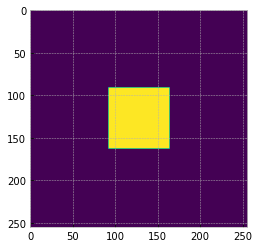

In [15]:
plt.imshow(zm2.cpu())

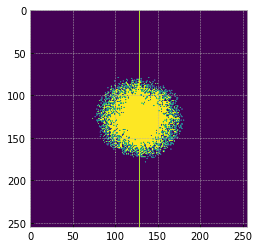

In [16]:
plt.imshow(w.cpu())

# Eval dice classes scores

In [52]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [8])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(32)//2 : 256//2 + int(32)//2] = 1
fm = torch.ones(256).cuda().float()
w = torch.load('sampling_igs.pt')[30]

In [53]:
dice_class_scores = dict(
    fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_on_classes_sampling_pattern(zm, model, val_generator),
    ours=test_on_classes_sampling_pattern(w, model, val_generator),
    full=test_on_classes_sampling_pattern(fm, model, val_generator),
)

In [54]:
class_map = {0: 'RV cavity', 1: 'LV myo', 2: 'LV cavity'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
        RV cavity      LV myo   LV cavity
count  514.000000  514.000000  514.000000
mean     0.381188    0.387448    0.593597
std      0.371435    0.232496    0.340607
min      0.000000    0.000000    0.000000
25%      0.000000    0.224808    0.412083
50%      0.333635    0.438446    0.743590
75%      0.771185    0.571852    0.858127
max      0.939749    0.769974    0.951340
############## center ##############
        RV cavity      LV myo   LV cavity
count  514.000000  514.000000  514.000000
mean     0.580750    0.669203    0.795335
std      0.386560    0.228259    0.279761
min      0.000000    0.000000    0.000000
25%      0.002825    0.622258    0.829225
50%      0.808927    0.756548    0.914425
75%      0.894388    0.816411    0.943239
max      0.965830    0.907721    0.974557
############## ours ##############
        RV cavity      LV myo   LV cavity
count  514.000000  514.000000  514.000000
mean     0.595818    0.689580    0.805002
std     

In [55]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).cuda().float()
w = torch.load('sampling_igs.pt')[14]

dice_class_scores = dict(
    fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_on_classes_sampling_pattern(zm, model, val_generator),
    ours=test_on_classes_sampling_pattern(w, model, val_generator),
    full=test_on_classes_sampling_pattern(fm, model, val_generator),
)

class_map = {0: 'RV cavity', 1: 'LV myo', 2: 'LV cavity'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())


############## fastmri ##############
        RV cavity      LV myo   LV cavity
count  514.000000  514.000000  514.000000
mean     0.342371    0.334447    0.565903
std      0.358415    0.214003    0.339937
min      0.000000    0.000000    0.000000
25%      0.000000    0.157670    0.282711
50%      0.193719    0.364101    0.719919
75%      0.742822    0.511418    0.832895
max      0.922642    0.723350    0.937900
############## center ##############
        RV cavity      LV myo   LV cavity
count  514.000000  514.000000  514.000000
mean     0.464225    0.497252    0.693303
std      0.380757    0.243481    0.328034
min      0.000000    0.000000    0.000000
25%      0.000000    0.377058    0.659942
50%      0.581346    0.590786    0.851644
75%      0.841381    0.672704    0.908577
max      0.954875    0.844853    0.959712
############## ours ##############
        RV cavity      LV myo   LV cavity
count  514.000000  514.000000  514.000000
mean     0.500341    0.547661    0.715802
std    